
                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 1, 8, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 1, 8, 5)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 12.53s


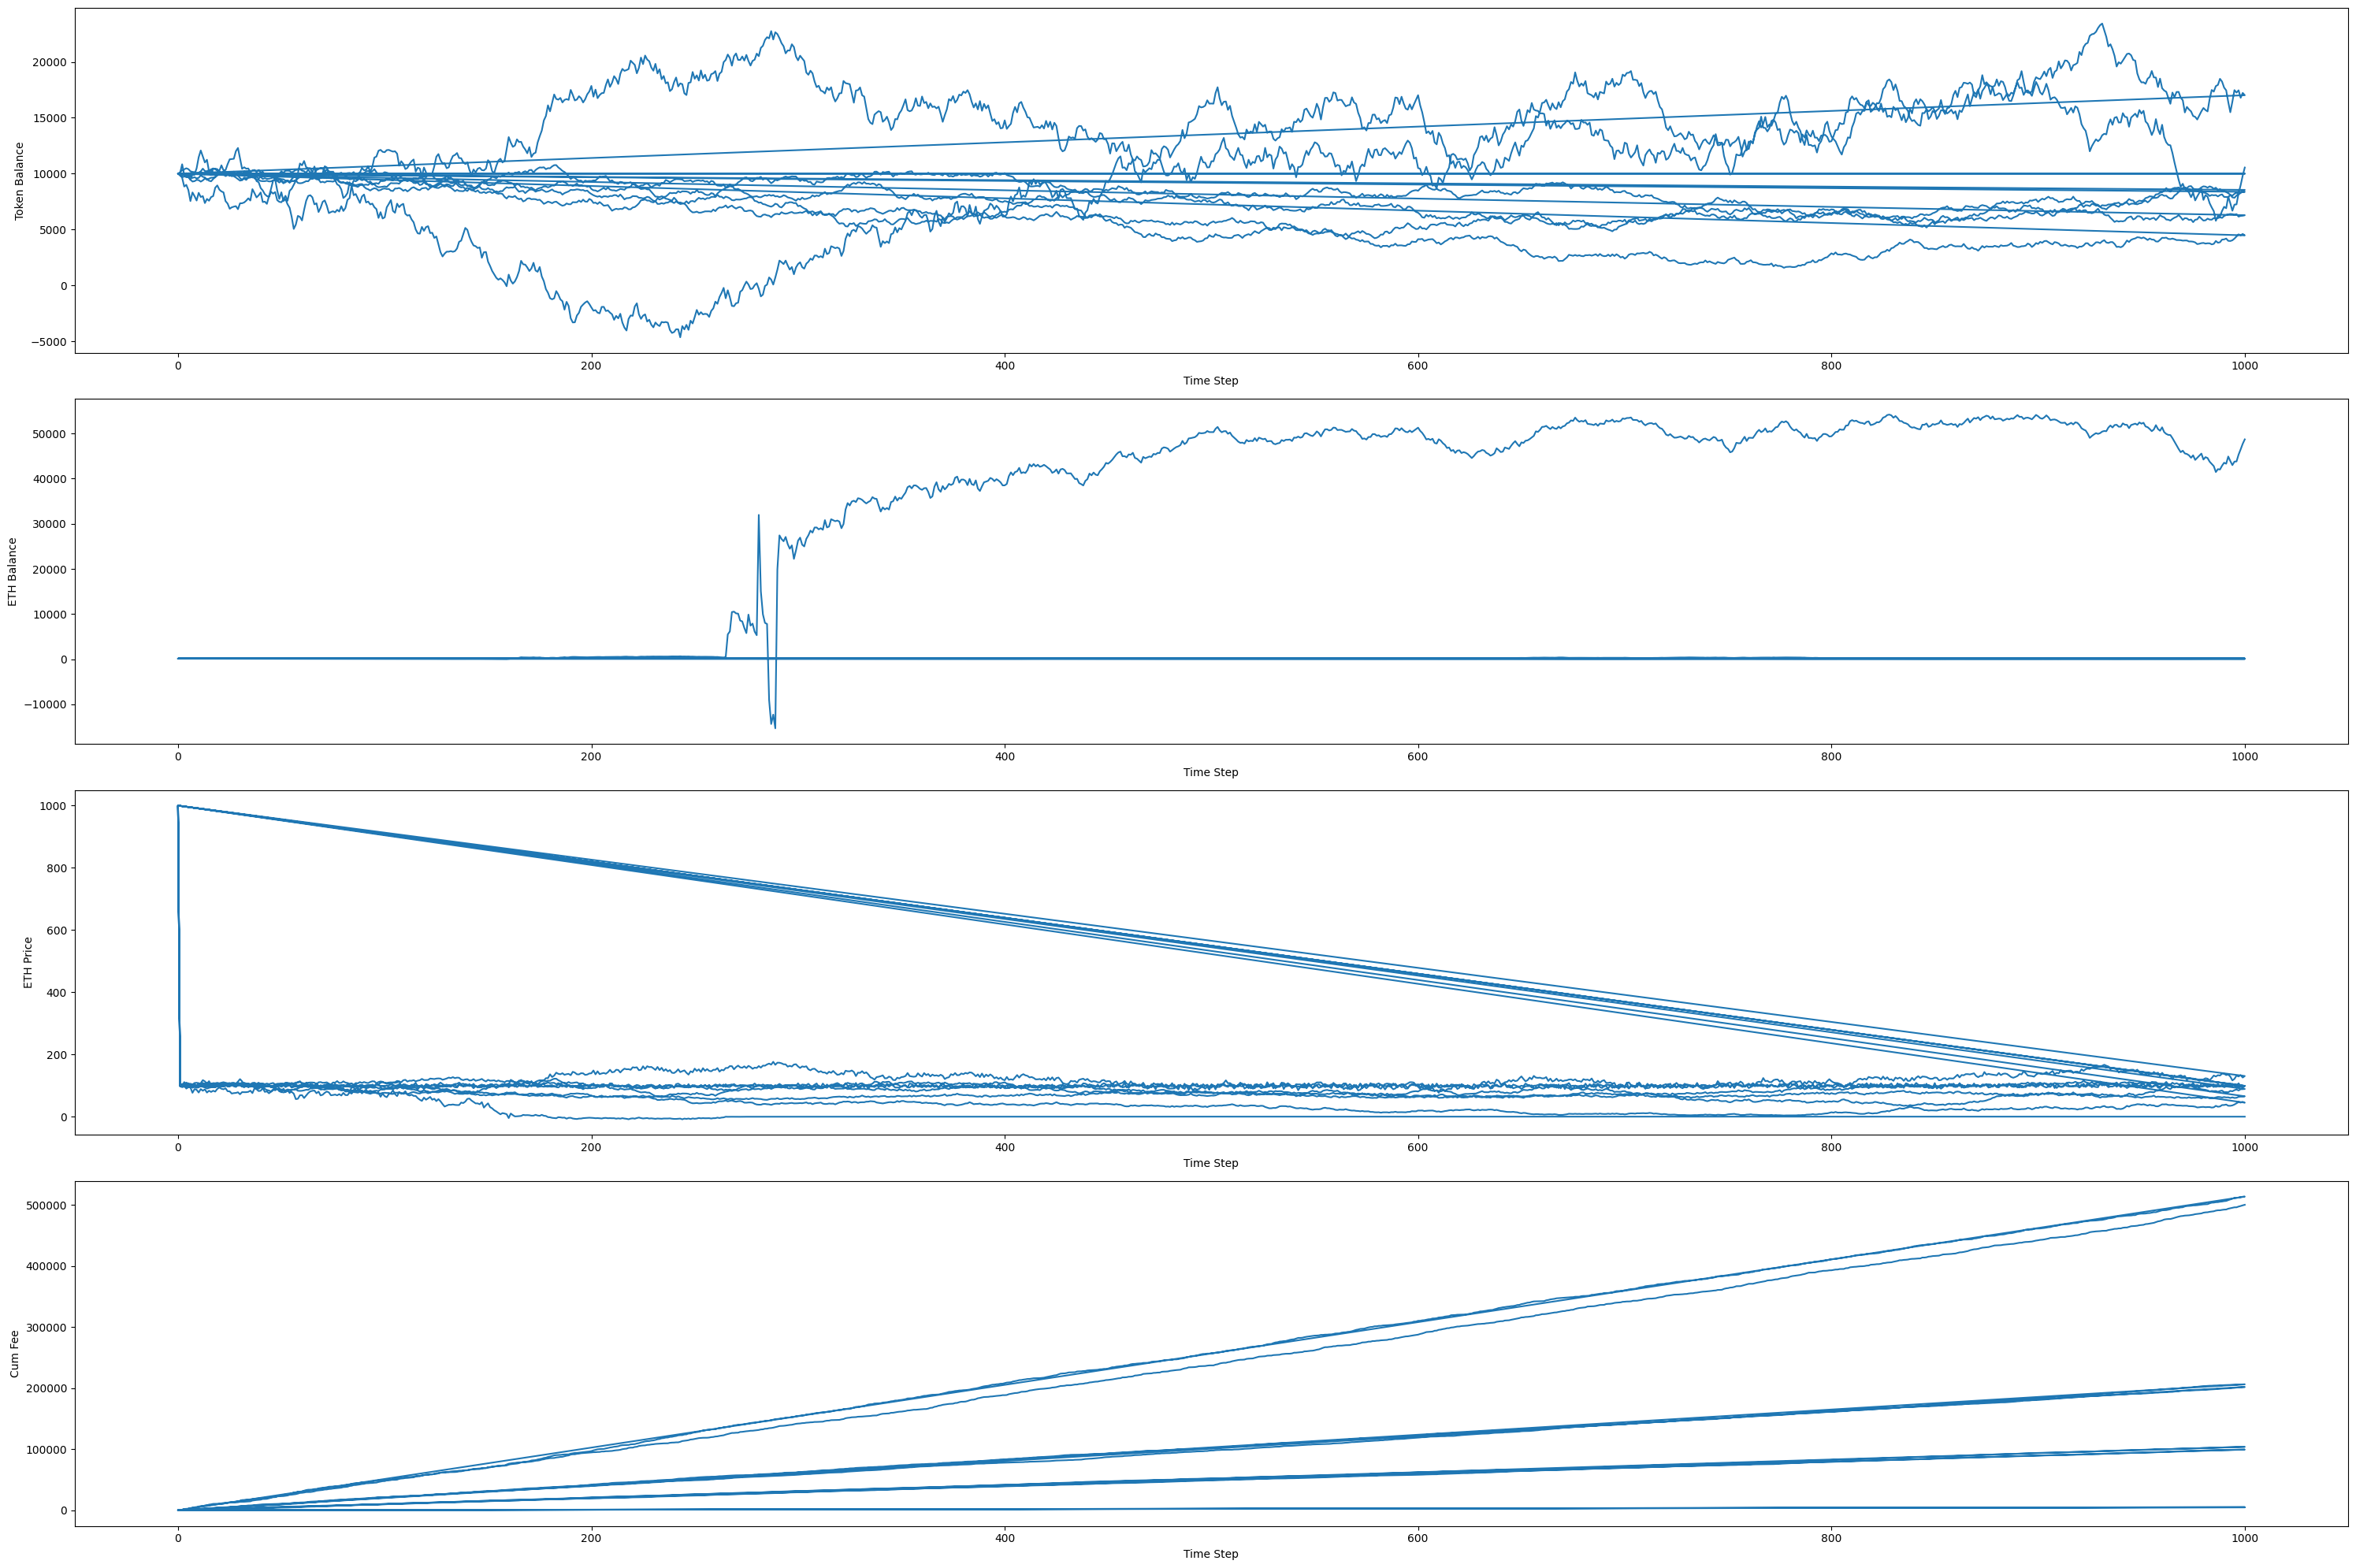

In [2]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
MONTE_CARLO_RUNS = 2
SIMULATION_TIMESTEPS = 1000

sys_params = {
    'swap_fee': [0.05,1,2,5]
}

genesis_states = {
    'eth_balance': 100, #Volatile asset
    'token_balance':10000, #Stablecoin
    'eth_price':1000, #volatile asset current price
    'cum_fee':0,
    'LPs':100
}

#State update functions
 
#Deposit tokens
def tokenToeth_swap_token(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    token_swap_amount = _input['swap_amount']
    fee_accum=token_swap_amount * sys_params['swap_fee']
    new_token_balance=prev_state['token_balance']+token_swap_amount-fee_accum
    return ('token_balance', new_token_balance)

#Get Eth
def tokenToeth_swap_eth(params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    token_swap_amount = _input['swap_amount']
    new_eth_balance=prev_state['eth_balance']-(token_swap_amount/prev_state['eth_price'])
    return ('eth_balance', new_eth_balance)

#update price 
def update_price_token(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    token_swap_amount = _input['swap_amount'] 
    new_token_balance=prev_state['token_balance']+token_swap_amount
    new_eth_balance=prev_state['eth_balance']-(token_swap_amount/prev_state['eth_price'])
    new_eth_price=new_token_balance/new_eth_balance
    return ('eth_price', new_eth_price)

def charge_fee_token(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    token_swap_amount = _input['swap_amount'] 
    new_fee=prev_state['cum_fee']+abs(token_swap_amount*sys_params['swap_fee'])
    return ('cum_fee', new_fee)

#Liquidity update function
def add_remove_liquidity_token(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    new_liquidity=prev_state["token_balance"]+_input["liquidity_amount"]
    return{"token_balance":new_liquidity}

def add_remove_liquidity_eth(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    new_liquidity=prev_state["eth_balance"]+ (_input["liquidity_amount"]/prev_state['eth_price'])
    return{"eth_balance":new_liquidity}

#Policy functions
def deposit_policy(params, step, sH, s):
    token_deposit_amount = np.random.uniform(low=200, high=500)
    return {'swap_amount': token_deposit_amount}

def withdraw_policy(params, step, sH, s):
    token_withdraw_amount =(-1)* np.random.uniform(low=200, high=500)
    return {'swap_amount': token_withdraw_amount}

def add_liquidity_policy(params,step,sH,s):
    add_liquidity_token=np.random.uniform(low=200,high=500)
    return{'liquidity_amount':add_liquidity_token}

def remove_liquidity_policy(params,step,sH,s):
    remove_liquidity_token=(-1)*np.random.uniform(low=200,high=500)
    return{'liquidity_amount':remove_liquidity_token}


#State update blocks
partial_state_update_blocks = [
    {
        'policies': {
            'deposit_policy':deposit_policy, #token deposit - withdraw eth
            'withdraw_policy': withdraw_policy #withdraw token - add eth 
        },
        'variables': {
            'token_balance': tokenToeth_swap_token,
            'eth_balance': tokenToeth_swap_eth,
            'eth_price': update_price_token,
            'cum_fee':charge_fee_token

            
        }
    }
  
]


sim_config = {
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
    'M': sys_params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)
#df.set_index('timestep')['token_balance'].plot()
#df.set_index('timestep')['eth_balance'].plot()
#df.set_index('timestep')['eth_price'].plot()
plt.figure(figsize=(30, 20))

plt.subplot(4, 1, 1)
plt.plot(df['timestep'], df['token_balance'])
plt.xlabel('Time Step')
plt.ylabel('Token Balance')

plt.subplot(4, 1, 2)
plt.plot(df['timestep'], df['eth_balance'])
plt.xlabel('Time Step')
plt.ylabel('ETH Balance')

plt.subplot(4, 1, 3)
plt.plot(df['timestep'], df['eth_price'])
plt.xlabel('Time Step')
plt.ylabel('ETH Price')

plt.subplot(4, 1, 4)
plt.plot(df['timestep'], df['cum_fee'])
plt.xlabel('Time Step')
plt.ylabel('Cum Fee')

plt.tight_layout()
plt.show()


In [ ]:
#Deposit eth
def ethTotoken_swap_token(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    eth_swap_amount = _input['eth_deposit_amount']
    fee_accum=eth_swap_amount*sys_params['swap_fee']
    prev_state['cum_fee']+=fee_accum  
    new_eth_balance=prev_state['eth_balance']+eth_swap_amount-fee_accum
    return ('token_balance', new_eth_balance)

#Get tokens
def ethTotoken_swap_eth(params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    eth_swap_amount = _input['eth_deposit_amount']
    new_token_balance=prev_state['token_balance']-(eth_swap_amount*prev_state['eth_price'])
    return ('eth_balance', new_token_balance)

def update_price_eth(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    eth_swap_amount = _input['eth_deposit_amount'] 
    new_eth_balance=prev_state['eth_balance']+eth_swap_amount
    new_token_balance=prev_state['token_balance']-(eth_swap_amount*prev_state['eth_price'])
    new_eth_price=new_token_balance/new_eth_balance
    return ('eth_price', new_eth_price)

def charge_fee_eth(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    eth_swap_amount = _input['eth_deposit_amount'] 
    prev_state['cum_fee']+=eth_swap_amount*sys_params['swap_fee']
    return ('cum_fee', prev_state['cum_fee'])


def add_remove_liquiidty(sys_params, 
                substep, 
                state_history, 
                prev_state, 
                _input):
    prev_pool_value=prev_state["token_balance"]+prev_state["eth_balance"]*prev_state["eth_price"]
    add_liquiidty_eth=_input["add_liquidity_token"]/prev_state["eth_price"]
    prev_state["eth_balance"]+=add_liquiidty_eth
    prev_state["token_balance"]+=_input["add_liquidity_token"]
    new_pool_value=prev_state["token_balance"]+prev_state["eth_balance"]*prev_state["eth_price"]
    LP_tokens_minted=(prev_pool_value/new_pool_value)*prev_state["LPs"]
    new_LPs=prev_state["LPs"]+LP_tokens_minted
    return{"LPs":new_LPs }
{
        'policies':{
            'add_liquidity_policy':add_liquidity_policy

        },
        'variables':{
            "LPs":add_remove_liquiidty

        }
    }

{'policies': {'add_liquidity_policy': <function __main__.add_liquidity_policy(params, step, sH, s)>},
 'variables': {'LPs': <function __main__.add_remove_liquiidty(sys_params, substep, state_history, prev_state, _input)>}}